## Загрузим нужные библиотеки

In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np 

# Графики
import seaborn as sns
import matplotlib.pyplot as plt

# Модели
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline


# Для multi-label classification
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multiclass import OneVsRestClassifier

# для дисбаланса классов - upsampling/downsampling
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import  RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Метрики
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import classification_report

# Нормализация
from sklearn.preprocessing import StandardScaler

# Векторизация текстов
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import coo_matrix, hstack

# Обработка текста и работа со словарями
import nltk
from wordcloud import WordCloud

import pymorphy2
import requests

from sklearn.feature_selection import chi2
%matplotlib inline

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Функции из других проектов

- Функции из текущего проекта

## Загрузка файлов

In [ ]:
# Доступ к файлам на colab
import glob
import os

# Библиотека для работы с google drive
from google.colab import drive

# Монтируем диск
drive.mount('/content/drive')

# Смотрим файлы в директории
# !ls "/content/drive/My Drive/Colab Notebooks"

Mounted at /content/drive


In [ ]:
# Меняем домашнюю директорию
# для доступа к датасетам
os.chdir("/content/drive/My Drive/Colab Notebooks/Цифровой прорыв - Вологодская область")

In [ ]:
df_train = pd.read_csv("train_dataset_train.csv")
df_test = pd.read_csv("test_dataset_test.csv")

## Функции для теста

#### (!) Пайплайн для предсказаний

- Опишем все предыдущие шаги в одной функции, которые мы делали на валидации

In [ ]:
def get_classes_predictions(target_classes_list, 
                            models_dictionary,
                            train_features, train_target,
                            test_features):

  # Датафрейм с предсказаниями
  predictions_dataset = pd.DataFrame([])

  for target_class in target_classes_list:

    # Обучаем  модель для каждого класса
    models_dictionary[target_class].fit(train_features, train_target[target_class])
    
   
    # Вычисляем вероятности классов на валидационной выборке
    predictions_dataset[target_class] = (models_dictionary[target_class]
                                  .predict_proba(test_features)[:, 1])  
    """  
    predictions_dataset[target_class] = (models_dictionary[target_class]
                                        .predict(test_features))
    """
  
  for target_class in target_classes_list:   
        predictions_dataset[target_class] = np.where(
            predictions_dataset[target_class] > 0.5, 1, 0)
      
  return predictions_dataset

#### (!) Вычисление метрики

In [ ]:
def calculate_multilabel_metrics(prediction_dataset, target_dataset, round_n=5):

  recall_scores = []
  precision_scores = []
  f1_scores = []

  # Вычисляем recall, precision и f1_score для каждого класса 
  for target_class in target_dataset.columns:

    # Recall
    recall_scores.append(
        recall_score(target_dataset[target_class],
                     prediction_dataset[target_class]).round(round_n)
        )
    
    # Precision
    precision_scores.append(
        precision_score(target_dataset[target_class],
                     prediction_dataset[target_class]).round(round_n)
        ) 
    
    # F1-score
    f1_scores.append(
        f1_score(target_dataset[target_class],
                     prediction_dataset[target_class]).round(round_n)
        ) 

  # Считаем средний Recall и Precision с равными весами для признаков
  class_weight = 1 / target_dataset.shape[1]
  
  avg_recall = (sum(recall_scores) * class_weight).round(round_n)
  avg_precision = (sum(precision_scores) * class_weight).round(round_n)
  avg_f1_score = (sum(f1_scores) * class_weight).round(round_n)

  recall_scores.append(avg_recall)
  precision_scores.append(avg_precision)  
  f1_scores.append(avg_f1_score) 

  return recall_scores, precision_scores, f1_scores

## ЭТАП 7. Итоговая версия

### Подготовка данных

#### Ключевые слова

In [128]:
# Словарь с ключевыми словами пресдказаний
best_words = {}


best_words['is_relevant'] = [
'акунин',
 'бабушка',
 'бедный',
 'близкий',
 'боль',
 'великий',
 'вера',
 'вечный',
 'выживание',
 'выживать',
 'выжить',
 'выпасть',
 'героиня',
 'голод',
 'грустный',
 'дарить',
 'деревня',
 'добро',
 'доброта',
 'добрый',
 'доля',
 'достоинство',
 'жизненный',
 'затянутый',
 'интересный',
 'испытание',
 'истина',
 'истинный',
 'история',
 'касаться',
 'любовь',
 'материнский',
 'меняться',
 'мужество',
 'мужчина',
 'надежда',
 'настоящий',
 'находить',
 'ненависть',
 'несправедливость',
 'нетерпение',
 'обстоятельство',
 'одиночество',
 'окружающий',
 'оставаться',
 'ощущать',
 'передать',
 'пережить',
 'повествовать',
 'право',
 'предательство',
 'предок',
 'приходить',
 'проблема',
 'прожить',
 'прошлый',
 'ради',
 'раскулачивание',
 'ребёнок',
 'родина',
 'родитель',
 'родиться',
 'родный',
 'светлый',
 'свобода',
 'семья',
 'сильный',
 'ситуация',
 'сложный',
 'слушать',
 'смерть',
 'собственный',
 'способный',
 'среди',
 'страх',
 'страшный',
 'судьба',
 'счастие',
 'сюжет',
 'трагедия',
 'трудность',
 'тысяча',
 'тяжело',
 'тяжёлый',
 'удовольствие',
 'умение',
 'умный',
 'условие',
 'учёный',
 'хрупкий',
 'цель',
 'человеческий',
 'человечность',
 'чтец']


best_words['has_value'] = [
 'абзац',
 'акунин',
 'арсений',
 'биография',
 'близкий',
 'бороться',
 'борьба',
 'бумага',
 'бывать',
 'бытие',
 'вера',
 'верность',
 'витиеватый',
 'власть',
 'внешний',
 'внимание',
 'внутренний',
 'воля',
 'впечатлительный',
 'второе',
 'высота',
 'действительность',
 'деревня',
 'держать',
 'добро',
 'доброта',
 'добротный',
 'добрый',
 'долг',
 'достоверность',
 'достоинство',
 'духовный',
 'душевный',
 'дыхание',
 'единый',
 'жажда',
 'жалость',
 'заниматься',
 'заслуживать',
 'затягивать',
 'здорово',
 'значение',
 'игнат',
 'идеальный',
 'илья',
 'иной',
 'искренний',
 'искренность',
 'испытание',
 'истина',
 'калабин',
 'крестьянин',
 'кусочек',
 'любищев',
 'любовь',
 'лёгкий',
 'лёгкость',
 'маркес',
 'материнский',
 'мечта',
 'миллион',
 'минус',
 'многое',
 'мужество',
 'мужчина',
 'мурашка',
 'мысль',
 'надежда',
 'наполнить',
 'напряжение',
 'нежность',
 'необходимый',
 'неожиданность',
 'неплохой',
 'несправедливость',
 'нетерпение',
 'нить',
 'нудно',
 'образец',
 'обращать',
 'обрываться',
 'обычай',
 'обычный',
 'окружающий',
 'опыт',
 'ответственность',
 'отношение',
 'очередной',
 'очередь',
 'ошибка',
 'пара',
 'парень',
 'переворачивать',
 'переживание',
 'переселенец',
 'петя',
 'план',
 'победа',
 'повесть',
 'поиск',
 'показать',
 'положение',
 'помогать',
 'поначалу',
 'постоянный',
 'право',
 'предательство',
 'предок',
 'представление',
 'придавать',
 'приключенческий',
 'пример',
 'приходиться',
 'приём',
 'проделать',
 'продолжение',
 'прожить',
 'произведение',
 'простота',
 'психологический',
 'раскулачить',
 'рассказать',
 'рассказывать',
 'растянуть',
 'реальность',
 'революция',
 'река',
 'респект',
 'решать',
 'ритм',
 'родина',
 'свобода',
 'связь',
 'сегодняшний',
 'семья',
 'сибирь',
 'сломать',
 'смерть',
 'собираться',
 'собрать',
 'совесть',
 'современный',
 'сосед',
 'сострадание',
 'сочувствие',
 'спасти',
 'справедливость',
 'старославянский',
 'страсть',
 'страшно',
 'суровый',
 'существование',
 'счастие',
 'сюжет',
 'татарин',
 'терпение',
 'точка',
 'труд',
 'трудность',
 'трудный',
 'уважение',
 'удаться',
 'удовольствие',
 'уклад',
 'умереть',
 'умно',
 'уничтожить',
 'условие',
 'успеть',
 'учитель',
 'фамилия',
 'фильм',
 'хрупкий',
 'цель',
 'ценность',
 'чапаев',
 'человеческий',
 'человечность',
 'честность',
 'чистый',
 'шанс',
 'эмоция',
 'эпоха',
 'юность',
 'яркий']


best_words['taks_relevant'] = [
    
 'бабушка',
 'боль',
 'буря',
 'виктор',
 'воспоминание',
 'вселенная',
 'выживать',
 'вызывать',
 'выпасть',
 'герой',
 'главное',
 'голод',
 'дедушка',
 'действие',
 'депрессия',
 'детство',
 'доля',
 'жалость',
 'житие',
 'испытание',
 'история',
 'материнство',
 'меняться',
 'наказание',
 'находить',
 'нелёгкий',
 'несправедливость',
 'озвучка',
 'окунуться',
 'олегович',
 'описать',
 'пелевин',
 'переживать',
 'пережить',
 'поколение',
 'положительный',
 'право',
 'предок',
 'преступление',
 'продолжение',
 'проживать',
 'пронзительный',
 'прослушать',
 'раскулачивание',
 'родина',
 'свежий',
 'семья',
 'сломать',
 'слушать',
 'сопереживание',
 'сопереживать',
 'ссылка',
 'столько',
 'страх',
 'судьба',
 'счастливый',
 'трагичный',
 'тысяча',
 'условие',
 'учебник',
 'фильм',
 'характер',
 'холод',
 'эмоция']


best_words['taks_non_relevant'] = [
 'анча',
 'аудио',
 'бабушкин',
 'безграмотный',
 'бильярд',
 'болото',
 'бояшов',
 'бутылка',
 'вампир',
 'версия',
 'виктор',
 'вирус',
 'восстание',
 'выражение',
 'выход',
 'гузель',
 'декабрист',
 'дурак',
 'залезть',
 'замирать',
 'заполнять',
 'застенок',
 'зачаровать',
 'игра',
 'известно',
 'катин',
 'коренной',
 'красноярск',
 'лечение',
 'ложка',
 'любищев',
 'материться',
 'многосерийный',
 'могила',
 'мурь',
 'надеяться',
 'немалый',
 'ненужный',
 'несвязный',
 'несомненно',
 'нетерпение',
 'нефть',
 'новинка',
 'оборваться',
 'обрываться',
 'олегович',
 'основа',
 'основной',
 'песня',
 'петров',
 'пластиковый',
 'познавательный',
 'полуслово',
 'поселение',
 'поучительный',
 'пощёчина',
 'прерываться',
 'престол',
 'приступить',
 'присущий',
 'проваливаться',
 'продолжение',
 'просмотр',
 'разговаривать',
 'рама',
 'режиссёр',
 'резать',
 'сахновский',
 'север',
 'серия',
 'символ',
 'скотина',
 'следующий',
 'снег',
 'снимать',
 'снятой',
 'снять',
 'совершенство',
 'стрелка',
 'тобол',
 'толчок',
 'требовать',
 'убийство',
 'учёт',
 'философско',
 'фильм',
 'хаматовый',
 'хотеться',
 'хочеться',
 'хутор',
 'целостный',
 'церковнославянский',
 'чулпан',
 'шалвович',
 'шамильевич',
 'эвакуатор',
 'экран']

best_words['taks_non_relevant2'] = [
 'анча',
 'аудио',
 'бильярд',
 'борис',
 'бояшов',
 'бутылка',
 'вампир',
 'васька',
 'версия',
 'выход',
 'игра',
 'катин',
 'коренной',
 'любищев',
 'могила',
 'мурь',
 'надеяться',
 'ненужный',
 'нетерпение',
 'обрываться',
 'основа',
 'петров',
 'пластиковый',
 'полуслово',
 'престол',
 'продолжение',
 'просмотр',
 'рама',
 'режиссёр',
 'сахновский',
 'серия',
 'снег',
 'снимать',
 'снятой',
 'снять',
 'тобол',
 'учёт',
 'фильм',
 'хаматовый',
 'хотеться',
 'хутор',
 'чулпан',
 'эвакуатор']

best_words['is_review_long'] = [
 'абсолютно',
 'авиатор',
 'аудиокнига',
 'благодарный',
 'виктор',
 'восторг',
 'впечатление',
 'вроде',
 'выжить',
 'герой',
 'глава',
 'далее',
 'достоверность',
 'душевно',
 'душевный',
 'задевать',
 'заставлять',
 'захватывать',
 'знакомство',
 'изучать',
 'история',
 'классический',
 'красиво',
 'красота',
 'мнение',
 'многие',
 'молодой',
 'никак',
 'нравиться',
 'обстоятельство',
 'отзыв',
 'отличный',
 'ощущение',
 'писатель',
 'поволжье',
 'позволять',
 'познавательный',
 'положение',
 'полюбить',
 'предложение',
 'прежде',
 'пронизать',
 'прослушать',
 'ребёнок',
 'серия',
 'скучный',
 'сопереживать',
 'стиль',
 'судьба',
 'тема',
 'точно',
 'увлекательно',
 'уровень',
 'успех',
 'устройство',
 'фраза',
 'ценить',
 'читатель',
 'читать',
 'эмоция']


In [129]:
print("Количество ключевых слов")
for target_class in best_words.keys():
  print(f"для {target_class}:",
        len(best_words[target_class]))

Количество ключевых слов
для is_relevant: 94
для has_value: 185
для taks_relevant: 64
для taks_non_relevant: 97
для taks_non_relevant2: 43
для is_review_long: 60


#### Модели и пайплайны

In [130]:
# Загружаем предобработанный датасет
df_review = pd.read_csv("dataset_with_lemmas.csv", sep=";").dropna()


# Словарь признаков для предсказания 'is_relevant' и 'is_review_long'
best_words_1 = ['герой', 'читать', 'автор', 'произведение', 'прочитать', 'понравиться']
best_words_2 = ['любовь', 'история', 'судьба', 'герой', 'близкий', 'сильный']
best_words_3 = list(pd.read_csv("key_features_relevant_linear_130.csv", sep=";").word)


# Модель Решающего Дерева с балансировкой (для большого словаря)
model_dt = DecisionTreeClassifier(max_features=2, 
                                  class_weight='balanced', 
                                  random_state=123)

# Модель Случайного Леса с балансировкой (для короткого набора слов)
model_rf_balanced = RandomForestClassifier( 
                             max_depth=15,
                             n_estimators=100,
                             max_features=2,
                             class_weight='balanced',
                             random_state=532)

model_rf = RandomForestClassifier(max_depth=15, max_features=2, random_state=532)

target_features = [
 'is_relevant',
 'taks_relevant',
 'taks_non_relevant',
 'is_review_long',
 'has_value']

In [131]:
import imblearn

# Пайплайны для предсказания каждого признака

models_dict = {}


# Пайплайн для  'is_relevant'
models_dict['is_relevant'] = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(vocabulary=best_words['is_relevant'], binary=True)),
    # ('oversampler', RandomUnderSampler(random_state=777, sampling_strategy= 0.7)),
    ('model', LogisticRegression(
                                 class_weight='balanced',
                                 max_iter=1000, 
                                 C=5, penalty='l2', random_state=12) )
])


# Пайплайн для  'taks_relevant'
models_dict['taks_relevant'] = Pipeline([
    ('tfidf', TfidfVectorizer(vocabulary=best_words['taks_relevant'], binary=True)),
    ('model',  RandomForestClassifier())
])

# Пайплайн для  'taks_non_relevant'
models_dict['taks_non_relevant'] = imblearn.pipeline.Pipeline([ 
    ('tfidf', TfidfVectorizer(vocabulary=best_words['taks_non_relevant2'], binary=True)),
    # ('oversampler', RandomOverSampler(random_state=777, sampling_strategy= 0.2)),
    ('model', RandomForestClassifier(class_weight='balanced'))
])


# Пайплайн для  'is_review_long'
models_dict['is_review_long'] = imblearn.pipeline.Pipeline([
    ('tfidf', TfidfVectorizer(vocabulary=best_words['is_review_long'], binary=True)),
    # ('oversampler', RandomOverSampler(random_state=777, sampling_strategy= 0.4)),
    ('model', LogisticRegression(class_weight='balanced'))
])

# Пайплайн для  'has_value'
models_dict['has_value'] = Pipeline([
    ('tfidf', TfidfVectorizer(vocabulary=best_words['has_value'], binary=True)),   
    ('model', LogisticRegression())
]) 

### Результаты на валидации (только токены-признаки)

In [132]:
df_review['tag_sum'] = df_review[target_features].sum(axis=1)

In [133]:
# Удаляем из обучения отзывы без тэгов
df_ml = df_review.query('tag_sum > 0').copy()

# Делаем замену слов
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('прочитать', 'читать', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('прочесть', 'читать', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('читаться', 'читать', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('читать', 'чтение', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('чтение', 'прочтение', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('чтец', 'читатель', regex=True)

df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('выживать', 'выживание', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('пережить', 'выживание', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('выжить', 'выживание', regex=True)

df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('доброта', 'добрый', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('добрый', 'добро', regex=True)

df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('тяжело', 'тяжелый', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('страшный', 'страх', regex=True)

df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('сопереживать', 'сопереживание', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('вспоминать', 'воспоминание', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('вспоминаться', 'воспоминание', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('вспомнить', 'воспоминание', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('вспомниться', 'воспоминание', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('выжить', 'выживание', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('голодать', 'голод', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('голодуха', 'голод', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('сопереживать', 'сопереживание', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('сопережевание', 'сопереживание', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('переживать', 'пережить', regex=True)
df_ml['lemmas_no_stop'] = df_ml['lemmas_no_stop'].str.replace('поломать', 'сломать', regex=True)


In [134]:
# Разделяем выборки
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(
    df_ml['lemmas_no_stop'],
    df_ml[target_features],
    test_size=0.2,
    random_state=123)

# Датафрейм с предсказаниями
df_predictions = pd.DataFrame([])

# Генерируем предсказания
df_predictions = get_classes_predictions(
    target_features, 
    models_dict,
    X_train_cv, 
    y_train_cv[target_features],
    X_valid)

# Здесь будем сохранять результаты 
df_results = pd.DataFrame(index=[target_features + ['average']])

df_results['recall_score'], df_results['precision_score'], df_results['f1_score'] = calculate_multilabel_metrics(df_predictions,  y_valid)

df_results

,recall_score,precision_score,f1_score
is_relevant,0.76077,0.45170,0.56684
taks_relevant,0.94444,0.98996,0.96667
taks_non_relevant,0.92500,1.00000,0.96104
is_review_long,0.83186,0.40693,0.54651
has_value,0.87430,0.78716,0.82844
average,0.86727,0.72715,0.77390


In [135]:
df_review['lemmas_no_stop'].shape

(4838,)

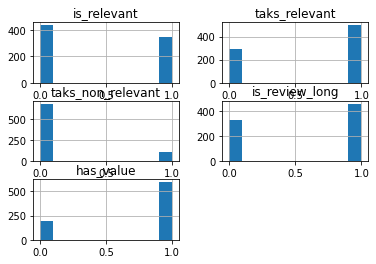

In [136]:
df_predictions.hist();

In [137]:
df_predictions.columns

Index(['is_relevant', 'taks_relevant', 'taks_non_relevant', 'is_review_long',
       'has_value'],
      dtype='object')

### Результаты на тесте

#### Текстовые признаки

In [162]:
def delete_similar_words(data):
  
  df = data.copy()
  # Делаем замену похожих слов
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('прочитать', 'читать', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('прочесть', 'читать', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('читаться', 'читать', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('читать', 'чтение', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('чтение', 'прочтение', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('чтец', 'читатель', regex=True)

  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('выживать', 'выживание', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('пережить', 'выживание', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('выжить', 'выживание', regex=True)

  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('доброта', 'добрый', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('добрый', 'добро', regex=True)

  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('тяжело', 'тяжелый', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('страшный', 'страх', regex=True)


  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('сопереживать', 'сопереживание', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('вспоминать', 'воспоминание', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('вспоминаться', 'воспоминание', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('вспомнить', 'воспоминание', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('вспомниться', 'воспоминание', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('выжить', 'выживание', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('голодать', 'голод', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('голодуха', 'голод', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('сопереживать', 'сопереживание', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('сопережевание', 'сопереживание', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('переживать', 'пережить', regex=True)
  df['lemmas_no_stop'] = df['lemmas_no_stop'].str.replace('поломать', 'сломать', regex=True)  

  return df


In [163]:
# Целевые признаки 
target_features = [
#  'is_relevant',
 'taks_relevant',
 'taks_non_relevant',
#  'is_review_long',
 'has_value']


# Загружаем предобработанный датасет
df_review_test = pd.read_csv("test_dataset_with_lemmas.csv", sep=";")
df_review = pd.read_csv("dataset_with_lemmas.csv", sep=";").dropna()

# Удаляем из обучения отзывы без тэгов
# df_review = df_review.query('tag_sum > 0').copy()

# Удаляем из текстов синонимы ключевых слов (эксперимент)
df_review = delete_similar_words(df_review)
df_review_test =  delete_similar_words(df_review_test)

# Обучаем модели на полной обучающей выборке
# Сохраняем предсказания классов на тесте
df_predictions = get_classes_predictions(
    target_features, 
    models_dict,
    df_review['lemmas_no_stop'], 
    df_review[target_features],
    df_review_test['lemmas_no_stop'])

df_predictions

,taks_relevant,taks_non_relevant,has_value
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,1,0,0
...,...,...,...
2070,1,1,0
2071,0,1,0
2072,1,0,1
2073,1,0,1


#### Добавляем комбинированные признаки для `is_relevant`

In [164]:
df_review = df_review.merge(
    df_train[['rating', 'rating_count', 
              'review_count',  'user_rating', 
              'review_text', 'review_likes',
              'review_dislikes']],
    on='review_text'
)

df_review_test = df_review_test.rename(columns={'Дислайки на отзыв':'review_dislikes',
                                                'Лайки на отзыв':'review_likes'})
df_review_test['review_length_text'] = df_review_test['review_text'].apply(lambda x: len(x))
df_review['review_length_text'] = df_review['review_text'].apply(lambda x: len(x))

dense_features = [           
  'review_likes'
]           

class_features = [
    'has_value',
    'taks_non_relevant',  
]

# Подготовка признаков
def features_preprocessing(dataset):
  df = dataset.copy()
  df['taks_non_relevant'] = df['taks_non_relevant'] / 5
  df['has_value'] = df['has_value'] / 5
  df['review_likes'] = df['review_likes'] / 16
  
  return df

# Добавляем предсказания признаков в тестовый датасет для обучения
# Используем values для игнорирования индексов
for feature in class_features:
  df_review_test[feature] = df_predictions[feature].values

df_review = features_preprocessing(df_review)
df_review_test = features_preprocessing(df_review_test)

In [165]:
# Готовим матрицу векторов TF-IDF для обучающей и валидационной выборки
tfidf_vectorizer = TfidfVectorizer(vocabulary=best_words['is_relevant'],
                                   binary=True)

tfidf_vectorizer.fit(df_review['lemmas_no_stop'])

tfidf_train = tfidf_vectorizer.transform(df_review['lemmas_no_stop'])
tfidf_test = tfidf_vectorizer.transform(df_review_test['lemmas_no_stop'])

# Добавляем в матрицу tf-idf дополнительные признаки по горизонтали
# Матрицу(вектор) с признаком трансформируем
tfidf_train = hstack((
        tfidf_train * 0.45, 
        coo_matrix(df_review[dense_features]) 
        ))

tfidf_test= hstack((
        tfidf_test * 0.45 , 
        coo_matrix(df_review_test[dense_features]) 
        ))  

# Обучаем модель и получаем предсказания
clf = LogisticRegression(class_weight='balanced', 
                         max_iter=1000, 
                         C=5, penalty='l2', random_state=12) 

clf.fit(tfidf_train, df_review['is_relevant'])
df_predictions['is_relevant'] = clf.predict(tfidf_test)

df_predictions

,taks_relevant,taks_non_relevant,has_value,is_relevant
0,0,0,1,1
1,1,0,0,0
2,0,0,1,1
3,0,0,1,0
4,1,0,0,1
...,...,...,...,...
2070,1,1,0,0
2071,0,1,0,0
2072,1,0,1,1
2073,1,0,1,1


#### Добавляем комбинированные признаки для `is_review_long`


- Дополнительные признаки 'review_length_text', 'review_dislikes'
- Целевые признаки:
    'has_value',         
    'taks_relevant', 
    'is_relevant', 
    'taks_non_relevant'

In [166]:
dense_features = [             
  'review_length_text',
  'review_dislikes' 
]           

class_features = [
    'has_value',         
    'taks_relevant', 
    'is_relevant', 
    'taks_non_relevant',   
]

# Добавляем предсказания признаков в тестовый датасет для обучения
# Используем values для игнорирования индексов
for feature in class_features:
  df_review_test[feature] = df_predictions[feature].values


In [167]:
# Готовим матрицу векторов TF-IDF для обучающей и валидационной выборки
tfidf_vectorizer = TfidfVectorizer(vocabulary=best_words_is_review_long2,
                                   binary=True)

tfidf_vectorizer.fit(df_review['lemmas_no_stop'])

tfidf_train = tfidf_vectorizer.transform(df_review['lemmas_no_stop'])
tfidf_test = tfidf_vectorizer.transform(df_review_test['lemmas_no_stop'])

# Добавляем в матрицу tf-idf дополнительные признаки по горизонтали
# Матрицу(вектор) с признаком трансформируем
tfidf_train = hstack((
        tfidf_train * 0.45, 
        coo_matrix(df_review[dense_features]) 
        ))

tfidf_test= hstack((
        tfidf_test * 0.45 , 
        coo_matrix(df_review_test[dense_features]) 
        ))  

# Обучаем модель и получаем предсказания
clf = LogisticRegression(class_weight='balanced', 
                         max_iter=2000, 
                         C=2, penalty='l2', random_state=12) 

clf.fit(tfidf_train, df_review['is_review_long'])
df_predictions['is_review_long'] = clf.predict(tfidf_test)

df_predictions

,taks_relevant,taks_non_relevant,has_value,is_relevant,is_review_long
0,0,0,1,1,1
1,1,0,0,0,1
2,0,0,1,1,0
3,0,0,1,0,0
4,1,0,0,1,1
...,...,...,...,...,...
2070,1,1,0,0,1
2071,0,1,0,0,1
2072,1,0,1,1,0
2073,1,0,1,1,1


- Готовим датасет для отправки

In [168]:
target_features = [
 'is_relevant',
 'taks_relevant',
 'taks_non_relevant',
 'is_review_long',
 'has_value']

# Сортируем столбцы в нужном порядке
df_predictions = df_predictions[target_features]

# Переименовываем столбцы  по условию задачи
df_predictions.columns = ['Релевантность', 'Таксономия релевантные',
                          'Таксономия не релевантные', 
                          'Длина отзыва', 'Ценности']

# Добавляем столбец с идентификаторами отзывов
df_predictions.insert(0, 'RecordNo', df_test['RecordNo'])

# Сохраняем датасет для теста на платформе
df_predictions.to_csv("predictions.csv", sep=",", index=False)
df_predictions

,RecordNo,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
0,3366,1,0,0,1,1
1,3952,0,1,0,1,0
2,6852,1,0,0,0,1
3,4586,0,0,0,0,1
4,4677,1,1,0,1,0
...,...,...,...,...,...,...
2070,4661,0,1,1,1,0
2071,1547,0,0,1,1,0
2072,6071,1,1,0,0,1
2073,3805,1,1,0,1,1


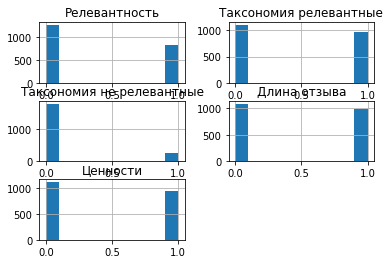

In [169]:
df_predictions.drop(['RecordNo'], axis=1).hist();

In [170]:
df_predictions.shape

(2075, 6)